In [7]:
import tensorflow as tf
import numpy as np
from sklearn.utils import shuffle


class BaseModel(object):
    def __init__(self, n_classes, n_features, learning_rate=0.1):
        self.n_classes = n_classes
        self.n_features = n_features
        self.sess = tf.InteractiveSession()
        self.weights_init()
        self.forward_pass()
        self.learning_rate = learning_rate
        self.cost_op()
        self.optimize_op()
        init = tf.global_variables_initializer()
        self.sess.run(init)

    @staticmethod
    def xavier_init(fan_in, fan_out, constant=1):
        """ Xavier initialization of network weights"""
        low = -constant*np.sqrt(6.0/(fan_in + fan_out))
        high = constant*np.sqrt(6.0/(fan_in + fan_out))
        return tf.random_uniform((fan_in, fan_out), minval=low,
                                 maxval=high, dtype=tf.float32)

    def forward_pass(self):
        with tf.name_scope("DNN"):
            hidden = tf.nn.relu(tf.add(tf.matmul(self.x,
                                self.variables["w_h"]),
                                self.variables["b_h"]))
            self.logits = tf.add(tf.matmul(hidden, self.variables["w_o"]),
                                 self.variables["b_o"])
            self.y_hat = tf.nn.softmax(self.logits)

    def weights_init(self):
        self.x = tf.placeholder(tf.float32, [None, self.n_features])
        self.y = tf.placeholder(tf.float32, [None, self.n_classes])
        self.variables = {}
        self.variables["w_h"] = tf.get_variable("w_h", initializer=
                                    self.xavier_init(self.n_features, 1000))
        self.variables["b_h"] = tf.get_variable("b_h",
                                                initializer=tf.zeros(1000))
        self.variables["w_o"] = tf.get_variable("w_o", initializer=
                                    self.xavier_init(1000, self.n_classes))
        self.variables["b_o"] = tf.get_variable("b_o",
                                        initializer=tf.zeros(self.n_classes))

    def cost_op(self):
        with tf.name_scope("cost"):
            self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
                                        logits=self.logits, labels=self.y))
        return self.cost

    def optimize_op(self):
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops):
            self.optimizer = tf.train.AdamOptimizer(
                        self.learning_rate).minimize(self.cost)
        return self.optimizer

    def train(self, X, Y, learning_rate=0.1, epochs=10, batch_size=100):
        N = X.shape[0]
        epoch_cost = []
        for e in range(epochs):
            total_cost = 0
            X, Y = shuffle(X, Y, random_state=0)
            for i in range(0, N, batch_size):
                train_X = X[i:i + batch_size]
                train_Y = Y[i:i + batch_size]
                c, _ = self.sess.run([self.cost, self.optimizer],
                                     feed_dict={self.x: train_X,
                                     self.y: train_Y})
                total_cost += c
            epoch_cost.append(total_cost)

    def predict(self, X):
        predictions = self.sess.run(self.y_hat, feed_dict={self.x: X})
        predictions = predictions.argmax(axis=1)
        return predictions


In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/Users/Blackbak/Downloads/mnist/")

Extracting /Users/Blackbak/Downloads/mnist/train-images-idx3-ubyte.gz
Extracting /Users/Blackbak/Downloads/mnist/train-labels-idx1-ubyte.gz
Extracting /Users/Blackbak/Downloads/mnist/t10k-images-idx3-ubyte.gz
Extracting /Users/Blackbak/Downloads/mnist/t10k-labels-idx1-ubyte.gz


In [3]:
x_train = mnist.train.images[:55000,:]
y_train = mnist.train.labels[:55000]
print(x_train.shape, y_train.shape)

(55000, 784) (55000,)


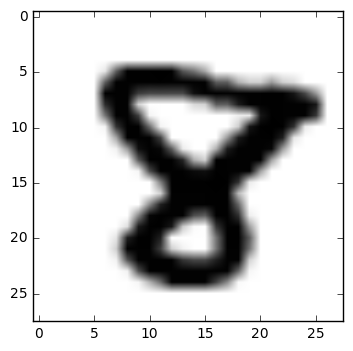

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline

randomNum = np.random.randint(0,55000)
image = x_train[randomNum].reshape([28,28])
plt.imshow(image, cmap=plt.get_cmap('gray_r'))
plt.show()

In [10]:
n_features = x_train.shape[1]
n_classes = len(np.unique(y_train))
base = BaseModel(n_features=n_features, n_classes=n_classes)

In [11]:
from sklearn.preprocessing import LabelBinarizer

y_train_onehot = LabelBinarizer().fit_transform(y_train)
base.train(X=x_train, Y=y_train_onehot)

In [12]:
predictions = base.predict(x_train)
print("Accuracy:",  (predictions==y_train).sum()/len(y_train))

Accuracy: 0.7424727272727273


In [32]:
class CnnModel(BaseModel):
    def conv2d(self, x, W):
        return tf.nn.conv2d(x, W, strides = [1, 1, 1, 1], padding = 'SAME')

    def max_pool_2x2(self, x):
        return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')

    def weight_variable(self, shape):
        initial = tf.truncated_normal(shape, stddev = 0.1)
        return tf.Variable(initial)

    def bias_variable(self, shape):
        initial = tf.constant(0.1, shape=shape)
        return tf.Variable(initial)

    def weights_init(self):
        self.x = tf.placeholder(tf.float32, [None, self.n_features])
        self.y = tf.placeholder(tf.float32, [None, self.n_classes])
        self.variables = {}
        #First Convolutional and Max Pool Layers
        self.variables["W_conv1"] = self.weight_variable([5, 5, 1, 32])
        self.variables["b_conv1"] = self.bias_variable([32])
        #Second Convolutional and Max Pool Layers
        self.variables["W_conv2"] = self.weight_variable([5, 5, 32, 64])
        self.variables["b_conv2"] = self.bias_variable([64])
        #Densely Connected Layer
        self.variables["W_fcl"] = self.weight_variable([7 * 7 * 64, 1024])
        self.variables["b_fcl"] = self.bias_variable([1024])
        #Output Layer (Softmax)
        self.variables["W_fc2"] = self.weight_variable([1024, 10])
        self.variables["b_fc2"] = self.bias_variable([10])

        
    def forward_pass(self):
        x = tf.reshape(self.x, [-1, 28, 28, 1])

        h_conv1 = tf.nn.relu(self.conv2d(x,self.variables["W_conv1"]) + self.variables["b_conv1"])
        h_pool1 = self.max_pool_2x2(h_conv1)

        h_conv2 = tf.nn.relu(self.conv2d(h_pool1, self.variables["W_conv2"]) + self.variables["b_conv2"])
        h_pool2 = self.max_pool_2x2(h_conv2)

        h_pool2_flat = tf.reshape(h_pool2, [-1, 7 * 7 * 64])
        h_fcl = tf.nn.relu(tf.matmul(h_pool2_flat, self.variables["W_fcl"]) + self.variables["b_fcl"])

        #Dropout
        h_fc1_drop = tf.nn.dropout(h_fcl, 0.5)

        self.logits = tf.matmul(h_fc1_drop, self.variables["W_fc2"]) + self.variables["b_fc2"]
        self.y_hat = tf.nn.softmax(self.logits)
        

In [33]:
n_features = x_train.shape[1]
n_classes = len(np.unique(y_train))
cnns = CnnModel(n_features=n_features, n_classes=n_classes)

In [35]:
y_train_onehot = LabelBinarizer().fit_transform(y_train)
cnns.train(X=x_train, Y=y_train_onehot)

KeyboardInterrupt: 

In [54]:
predictions = base.predict(x_train)
print("Accuracy:",  (predictions==y_train).sum()/len(y_train))

array([[5.3331077e-02, 3.0612955e-02, 3.7860077e-02, ..., 2.4726411e-02,
        5.8059049e-01, 3.9025962e-02],
       [0.0000000e+00, 5.3091700e-14, 5.9687408e-20, ..., 6.4688356e-04,
        2.0887164e-17, 2.7653847e-21],
       [3.6542475e-24, 7.5730895e-15, 5.3029021e-09, ..., 7.0180908e-02,
        6.5605556e-11, 9.1657770e-01],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [7.6876247e-30, 0.0000000e+00, 2.5245118e-16, ..., 0.0000000e+00,
        2.3981909e-36, 0.0000000e+00],
       [5.3331077e-02, 3.0612955e-02, 3.7860077e-02, ..., 2.4726411e-02,
        5.8059049e-01, 3.9025962e-02]], dtype=float32)